In [1]:
import pandas as pd
import numpy as np
from scipy.signal import detrend
from scipy.stats import norm
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [11]:
urls = {
    'n5' : '../data/model_out/ReturnOnSavings-5.csv',
    'n4' : '../data/model_out/ReturnOnSavings-4.csv',
    'n3' : '../data/model_out/ReturnOnSavings-3.csv',
    'n2' : '../data/model_out/ReturnOnSavings-2.csv',
    'n1' : '../data/model_out/ReturnOnSavings-1.csv',
    'p0' : '../data/model_out/ReturnOnSavings+0.csv',
    'p1' : '../data/model_out/ReturnOnSavings+1.csv',
    'p2' : '../data/model_out/ReturnOnSavings+2.csv',
    'p3' : '../data/model_out/ReturnOnSavings+3.csv',
}

In [12]:
ros_dct = dict()
dlt_dct = dict()
vlt_dct = dict()
hll_dct = dict()
aac_dct = dict()
count = list(['n5','n4','n3','n2','n1','p0','p1','p2','p3'])

for number in count:
    ros_dct[number] = pd.read_csv(urls[number])
    ros_dct[number] = ros_dct[number].add_suffix('r')
    ros_dct[number] = ros_dct[number].add_prefix('_')
    ros_dct[number] = ros_dct[number].apply(pd.to_numeric, errors = 'coerce')

    dlt_dct[number] = ros_dct[number].filter(regex='Deltas_', axis=1)
    dlt_dct[number].dropna(inplace=True)
    dlt_dct[number][number] = dlt_dct[number].mean(axis=1)   
    dlt_dct[number] = dlt_dct[number].iloc[:,-1:]

    vlt_dct[number] = ros_dct[number].filter(regex='Volatility_', axis=1)
    vlt_dct[number].dropna(inplace=True)
    vlt_dct[number][number] = vlt_dct[number].mean(axis=1)   
    vlt_dct[number] = vlt_dct[number].iloc[:,-1:]

    hll_dct[number] = ros_dct[number].filter(regex='_hillIdx_', axis=1)
    hll_dct[number].dropna(inplace=True)
    hll_dct[number][number] = hll_dct[number].mean(axis=1)   
    hll_dct[number] = hll_dct[number].iloc[:,-1:]

    aac_dct[number] = ros_dct[number].filter(regex='_AACFr_', axis=1)
    aac_dct[number].dropna(inplace=True)
    aac_dct[number][number] = aac_dct[number].mean(axis=1)   
    aac_dct[number] = aac_dct[number].iloc[:,-1:]

deltas = pd.concat(dlt_dct.values(), axis=1).T
deltas.columns = ['WAMS','Volatility','HillIDX','ACabsR']
deltas.set_index(pd.Index([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03]), inplace=True)

volas = pd.concat(vlt_dct.values(), axis=1).T
volas.columns = ['Vprice','Vreturn']
volas.set_index(pd.Index([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03]), inplace=True)

hlidxs = pd.concat(hll_dct.values(), axis=1).iloc[1:]
hlidxs.columns = [-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03]
hlidxs.set_index(pd.Index(ros_dct['p0']['_hillObs_1r'].iloc[1:].dropna()), inplace=True)

aacs = pd.concat(aac_dct.values(), axis=1).iloc[1:]
aacs.columns = [-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03]

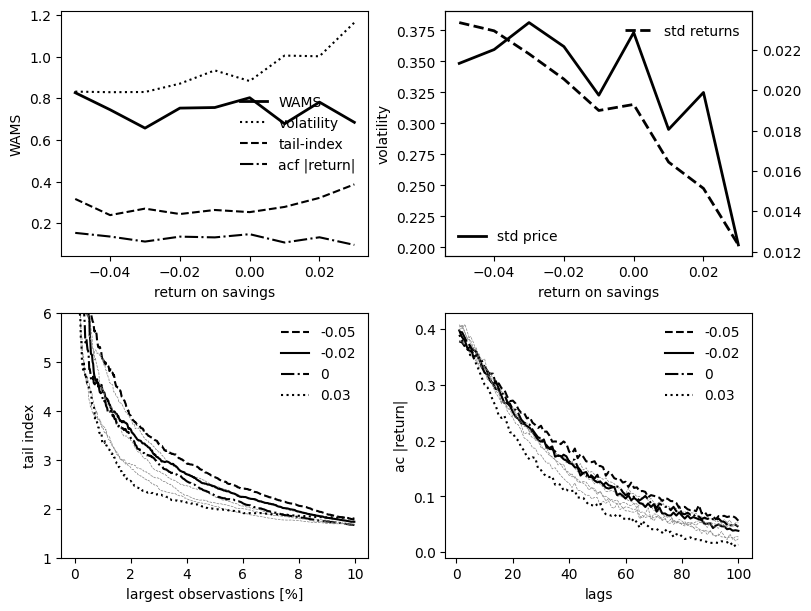

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(8,6))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0:1 , 0:1])
wams = ax1.plot(deltas.WAMS, color='black', linewidth=2, label= 'WAMS')
volatility = ax1.plot(deltas.Volatility / (0.2125 * 3), color='black', linestyle='dotted', label='volatility')
tailidx = ax1.plot(deltas.HillIDX / (0.1674 * 3), color='black', linestyle='dashed', label='tail-index')
autocor = ax1.plot(deltas.ACabsR / (3.8845 * 3), color='black', linestyle='dashdot', label='acf |return|')
ax1.set_ylabel('WAMS')
ax1.set_xlabel('return on savings')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, frameon=0)

ax2 = fig.add_subplot(gs[0:1 , 1:2])
vPrice = ax2.plot(volas.Vprice, color='black', linewidth=2, label='std price')
ax2.set_ylabel('volatility')
ax2.set_xlabel('return on savings')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(labels, loc='lower left', frameon=0)
ax22 = ax2.twinx() 
vReturns = ax22.plot(volas.Vreturn, color='black', linewidth=2, linestyle='dashed', label='std returns')
handles, labels = ax22.get_legend_handles_labels()
ax22.legend(labels, loc='upper right', frameon=0)

ax3 = fig.add_subplot(gs[1: , 0:1])
m5 = ax3.plot(hlidxs[-0.05], color='black', linewidth=1.5, linestyle='dashed', label='-0.05')
ax3.plot(hlidxs[-0.03], color='grey', linewidth=0.5, linestyle='dashed')
m2 = ax3.plot(hlidxs[-0.02], color='black', linewidth=1.5, label='-0.02')
ax3.plot(hlidxs[-0.01], color='grey', linewidth=0.5, linestyle='dashed')
m0 = ax3.plot(hlidxs[0], color='black', linewidth=1.5, linestyle='dashdot', label='0')
ax3.plot(hlidxs[0.01], color='grey', linewidth=0.5, linestyle='dashed')
ax3.plot(hlidxs[0.02], color='gray', linewidth=0.5, linestyle='dashed')
p3 = ax3.plot(hlidxs[0.03], color='black', linewidth=1.5, linestyle='dotted', label='0.03')
ax3.set_ylabel('tail index')
ax3.set_xlabel('largest observastions [%]')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, loc='upper right', frameon=0)
ax3.set_ylim([1,6])

ax4 = fig.add_subplot(gs[1: , 1:2])
m5 = ax4.plot(aacs[-0.05], color='black', linewidth=1.5, linestyle='dashed', label='-0.05')
ax4.plot(aacs[-0.04], color='grey', linewidth=0.5, linestyle='dashed')
ax4.plot(aacs[-0.03], color='grey', linewidth=0.5, linestyle='dashed')
m2 = ax4.plot(aacs[-0.02], color='black', linewidth=1.5, label='-0.02')
ax4.plot(aacs[-0.01], color='grey', linewidth=0.5, linestyle='dashed')
m0 = ax4.plot(aacs[0], color='black', linewidth=1.5, linestyle='dashdot', label='0')
ax4.plot(aacs[0.01], color='grey', linewidth=0.5, linestyle='dashed')
ax4.plot(aacs[0.02], color='gray', linewidth=0.5, linestyle='dashed')
p3 = ax4.plot(aacs[0.03], color='black', linewidth=1.5, linestyle='dotted', label='0.03')
ax4.set_ylabel('ac |return|')
ax4.set_xlabel('lags')
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, loc='upper right', frameon=0)

# plt.savefig(fname="return-on-savings-impact.svg", format="svg")
plt.show()


In [14]:
urls = {
    'True' : '../data/model_out/Save2Fund-True.csv',
    'False' : '../data/model_out/Save2Fund-False.csv',
}
s2f_dct = dict()
dlt_dct = dict()
vlt_dct = dict()
hll_dct = dict()
aac_dct = dict()
count = list(['True','False'])

for number in count:
    s2f_dct[number] = pd.read_csv(urls[number])
    s2f_dct[number] = s2f_dct[number].add_suffix('r')
    s2f_dct[number] = s2f_dct[number].add_prefix('_')
    s2f_dct[number] = s2f_dct[number].apply(pd.to_numeric, errors = 'coerce')

    dlt_dct[number] = s2f_dct[number].filter(regex='Deltas_', axis=1)
    dlt_dct[number].dropna(inplace=True)
    dlt_dct[number][number] = dlt_dct[number].mean(axis=1)   
    dlt_dct[number] = dlt_dct[number].iloc[:,-1:]

    vlt_dct[number] = s2f_dct[number].filter(regex='Volatility_', axis=1)
    vlt_dct[number].dropna(inplace=True)
    vlt_dct[number][number] = vlt_dct[number].mean(axis=1)   
    vlt_dct[number] = vlt_dct[number].iloc[:,-1:]

    hll_dct[number] = s2f_dct[number].filter(regex='_hillIdx_', axis=1)
    hll_dct[number].dropna(inplace=True)
    hll_dct[number][number] = hll_dct[number].mean(axis=1)   
    hll_dct[number] = hll_dct[number].iloc[:,-1:]

    aac_dct[number] = s2f_dct[number].filter(regex='_AACFr_', axis=1)
    aac_dct[number].dropna(inplace=True)
    aac_dct[number][number] = aac_dct[number].mean(axis=1)   
    aac_dct[number] = aac_dct[number].iloc[:,-1:]

deltas2 = pd.concat(dlt_dct.values(), axis=1).T
deltas2.columns = ['WAMS','Volatility','HillIDX','ACabsR']
deltas2.set_index(pd.Index(['True','False']), inplace=True)

delta_t = s2f_dct['True'].filter(regex='Deltas_', axis=1).dropna().T
delta_t.columns = ['WAMS','volatility','HillIDX','ACabsR']
delta_wt = pd.DataFrame()
delta_wt['WAMS'] = delta_t.WAMS
delta_wt['volatility'] = delta_t.volatility / (0.2125 * 3)
delta_wt['HillIDX'] = delta_t.HillIDX / (0.1674 * 3)
delta_wt['ACabsR'] = delta_t.ACabsR / (3.8845 * 3)

delta_f = s2f_dct['False'].filter(regex='Deltas_', axis=1).dropna().T
delta_f.columns = ['WAMS','volatility','HillIDX','ACabsR']
delta_wf = pd.DataFrame()
delta_wf['WAMS'] = delta_f.WAMS
delta_wf['volatility'] = delta_f.volatility / (0.2125 * 3)
delta_wf['HillIDX'] = delta_f.HillIDX / (0.1674 * 3)
delta_wf['ACabsR'] = delta_f.ACabsR / (3.8845 * 3)

volas2 = pd.concat(vlt_dct.values(), axis=1).T
volas2.columns = ['Vprice','Vreturn']
volas2.set_index(pd.Index(['True','False']), inplace=True)

vola_t = s2f_dct['True'].filter(regex='_Volatility_', axis=1).dropna().T
vola_t.columns = ['Price','Return']

vola_f = s2f_dct['False'].filter(regex='_Volatility_', axis=1).dropna().T
vola_f.columns = ['Price','Return']

hlidxs2 = pd.concat(hll_dct.values(), axis=1).iloc[1:]
hlidxs2.columns = ['True','False']
hlidxs2.set_index(pd.Index(s2f_dct['True']['_hillObs_1r'].iloc[1:].dropna()), inplace=True)

aacs2 = pd.concat(aac_dct.values(), axis=1).iloc[1:]
aacs2.columns = ['True','False']

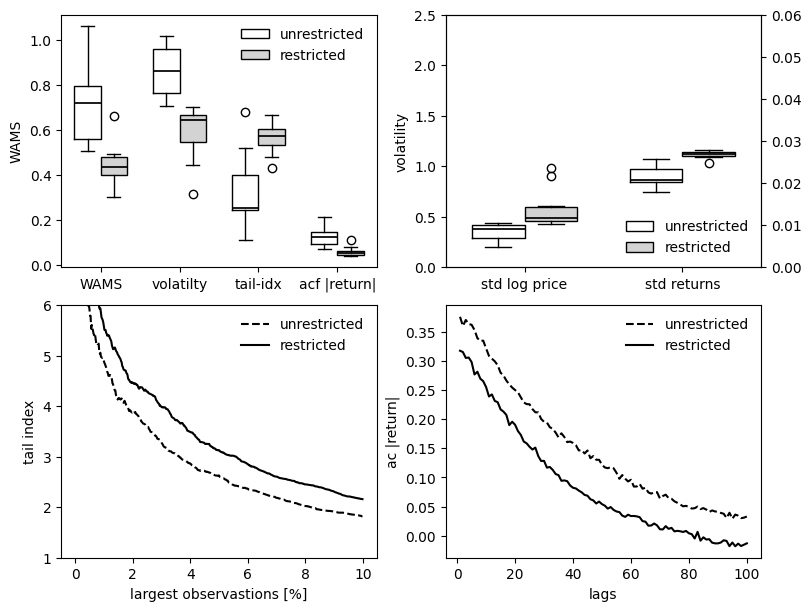

In [15]:
fig = plt.figure(constrained_layout=True, figsize=(8,6))
gs = GridSpec(2, 2, figure=fig)

pos_t, pos_f = [1,4,7,10], [2,5,8,11]
ax1 = fig.add_subplot(gs[0:1 , 0:1])
box_t = ax1.boxplot(delta_wt,positions=pos_t,widths=1)
box_f = ax1.boxplot(delta_wf,positions=pos_f,widths=1, patch_artist=True)
for median in box_t['medians']:
    median.set(color='black', linewidth=1.25)
for patch in box_f['boxes']:
    patch.set_facecolor('lightgray')
for median in box_f['medians']:
    median.set(color='black', linewidth=1.25)
ax1.set_xlim([0,12])
ax1.set_xticks([1.5,4.5,7.5,10.5], ['WAMS','volatilty','tail-idx','acf |return|'])
ax1.set_ylabel('WAMS')
white_patch = mpatches.Patch(facecolor='white', label='unrestricted', edgecolor='black')
grey_patch = mpatches.Patch(facecolor='lightgrey', label='restricted', edgecolor='black')
ax1.legend(handles=[white_patch, grey_patch], frameon=0)

ax2 = fig.add_subplot(gs[0:1 , 1:2])
box_t = ax2.boxplot(vola_t.Price,positions=[1],widths=1)
box_f = ax2.boxplot(vola_f.Price,positions=[2],widths=1, patch_artist=True)
ax22 = ax2.twinx() 
box2_t = ax22.boxplot(vola_t.Return,positions=[4],widths=1)
box2_f = ax22.boxplot(vola_f.Return,positions=[5],widths=1, patch_artist=True)
ax22.set_ylim([0,0.06])
for median in box_t['medians']:
    median.set(color='black', linewidth=1.25)
for patch in box_f['boxes']:
    patch.set_facecolor('lightgray')
for median in box_f['medians']:
    median.set(color='black', linewidth=1.25)
for median in box2_t['medians']:
    median.set(color='black', linewidth=1.25)
for patch in box2_f['boxes']:
    patch.set_facecolor('lightgray')
for median in box2_f['medians']:
    median.set(color='black', linewidth=1.25)
ax2.set_xlim([0,6])
ax2.set_ylim([0,2.5])
ax2.set_xticks([1.5,4.5], ['std log price','std returns'])
ax2.set_ylabel('volatility')
white_patch = mpatches.Patch(facecolor='white', label='unrestricted', edgecolor='black')
grey_patch = mpatches.Patch(facecolor='lightgrey', label='restricted',edgecolor='black')
ax2.legend(handles=[white_patch, grey_patch], loc='lower right', frameon=0)

ax3 = fig.add_subplot(gs[1: , 0:1])
t = ax3.plot(hlidxs2['True'], color='black', linewidth=1.5, linestyle='dashed', label='unrestricted')
f = ax3.plot(hlidxs2['False'], color='black', linewidth=1.5, label='restricted')
ax3.set_ylabel('tail index')
ax3.set_xlabel('largest observastions [%]')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, loc='upper right', frameon=0)
ax3.set_ylim([1,6])

ax4 = fig.add_subplot(gs[1: , 1:2])
t = ax4.plot(aacs2['True'], color='black', linewidth=1.5, linestyle='dashed', label='unrestricted')
f = ax4.plot(aacs2['False'], color='black', linewidth=1.5, label='restricted')
ax4.set_ylabel('ac |return|')
ax4.set_xlabel('lags')
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, loc='upper right', frameon=0)

# plt.savefig(fname="unrestricted-restricted-savers.svg", format="svg")
plt.show()

In [18]:
urls = {
    '0.003' : '../data/model_out/SaversReaction-003.csv',
    '0.01'  : '../data/model_out/SaversReaction-01.csv',
    '0.03'  : '../data/model_out/SaversReaction-03.csv',
    '0.1'   : '../data/model_out/SaversReaction-1.csv',
    '0.3'   : '../data/model_out/SaversReaction-3.csv',
}

rct_dct = dict()
dlt_dct = dict()
vlt_dct = dict()
hll_dct = dict()
aac_dct = dict()
count = list(['0.003','0.01','0.03','0.1','0.3'])

for number in count:
    rct_dct[number] = pd.read_csv(urls[number])
    rct_dct[number] = rct_dct[number].add_suffix('r')
    rct_dct[number] = rct_dct[number].add_prefix('_')
    rct_dct[number] = rct_dct[number].apply(pd.to_numeric, errors = 'coerce')

    dlt_dct[number] = rct_dct[number].filter(regex='Deltas_', axis=1)
    dlt_dct[number].dropna(inplace=True)
    dlt_dct[number][number] = dlt_dct[number].mean(axis=1)   
    dlt_dct[number] = dlt_dct[number].iloc[:,-1:]

    vlt_dct[number] = rct_dct[number].filter(regex='Volatility_', axis=1)
    vlt_dct[number].dropna(inplace=True)
    vlt_dct[number][number] = vlt_dct[number].mean(axis=1)   
    vlt_dct[number] = vlt_dct[number].iloc[:,-1:]

    hll_dct[number] = rct_dct[number].filter(regex='_hillIdx_', axis=1)
    hll_dct[number].dropna(inplace=True)
    hll_dct[number][number] = hll_dct[number].mean(axis=1)   
    hll_dct[number] = hll_dct[number].iloc[:,-1:]

    aac_dct[number] = rct_dct[number].filter(regex='_AACFr_', axis=1)
    aac_dct[number].dropna(inplace=True)
    aac_dct[number][number] = aac_dct[number].mean(axis=1)   
    aac_dct[number] = aac_dct[number].iloc[:,-1:]

deltas3 = pd.concat(dlt_dct.values(), axis=1).T
deltas3.columns = ['WAMS','Volatility','HillIDX','ACabsR']
deltas3.set_index(pd.Index(count), inplace=True)

volas3 = pd.concat(vlt_dct.values(), axis=1).T
volas3.columns = ['Vprice','Vreturn']
volas3.set_index(pd.Index(count), inplace=True)

hlidxs3 = pd.concat(hll_dct.values(), axis=1).iloc[1:]
hlidxs3.columns = count
hlidxs3.set_index(pd.Index(rct_dct['0.003']['_hillObs_1r'].iloc[1:].dropna()), inplace=True)

aacs3 = pd.concat(aac_dct.values(), axis=1).iloc[1:]
aacs3.columns = count

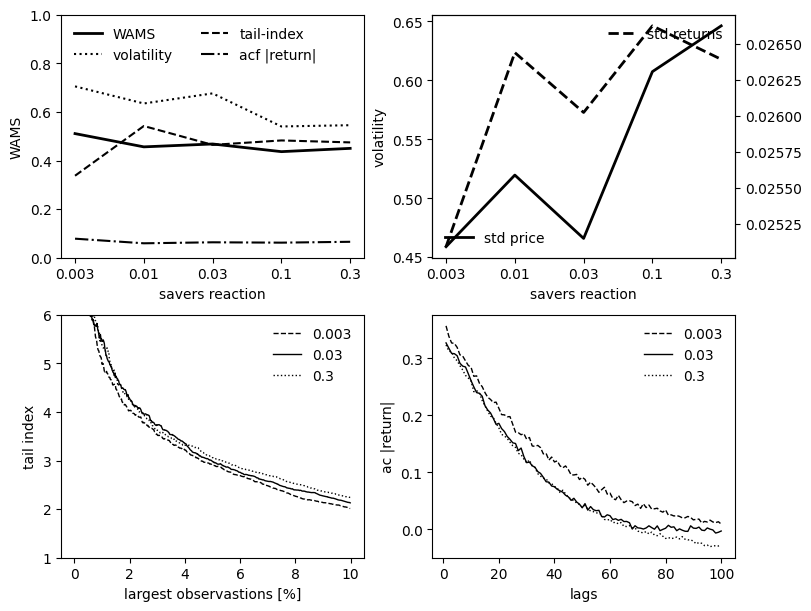

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(8,6))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0:1 , 0:1])
wams = ax1.plot(deltas3.WAMS, color='black', linewidth=2, label= 'WAMS')
volatility = ax1.plot(deltas3.Volatility / (0.2125 * 3), color='black', linestyle='dotted', label='volatility')
tailidx = ax1.plot(deltas3.HillIDX / (0.1674 * 3), color='black', linestyle='dashed', label='tail-index')
autocor = ax1.plot(deltas3.ACabsR / (3.8845 * 3), color='black', linestyle='dashdot', label='acf |return|')
ax1.set_ylabel('WAMS')
ax1.set_xlabel('savers reaction')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left', ncol=2, frameon=0)
ax1.set_ylim([0,1])

ax2 = fig.add_subplot(gs[0:1 , 1:2])
vPrice = ax2.plot(volas3.Vprice, color='black', linewidth=2, label='std price')
ax2.set_ylabel('volatility')
ax2.set_xlabel('savers reaction')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(labels, loc='lower left',frameon=0)
ax22 = ax2.twinx() 
vReturns = ax22.plot(volas3.Vreturn, color='black', linewidth=2, linestyle='dashed', label='std returns')
handles, labels = ax22.get_legend_handles_labels()
ax22.legend(labels, loc='upper right',frameon=0)

ax3 = fig.add_subplot(gs[1: , 0:1])
r003 = ax3.plot(hlidxs3['0.003'], color='black', linewidth=1, linestyle='dashed', label='0.003')
r03 = ax3.plot(hlidxs3['0.03'], color='black', linewidth=1, label='0.03')
r3 = ax3.plot(hlidxs3['0.3'], color='black', linewidth=1, linestyle='dotted', label='0.3')
ax3.set_ylabel('tail index')
ax3.set_xlabel('largest observastions [%]')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, loc='upper right',frameon=0)
ax3.set_ylim([1,6])

ax4 = fig.add_subplot(gs[1: , 1:2])
r003 = ax4.plot(aacs3['0.003'], color='black', linewidth=1, linestyle='dashed', label='0.003')
r03 = ax4.plot(aacs3['0.03'], color='black', linewidth=1, label='0.03')
r3 = ax4.plot(aacs3['0.3'], color='black', linewidth=1, linestyle='dotted', label='0.3')
ax4.set_ylabel('ac |return|')
ax4.set_xlabel('lags')
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, loc='upper right',frameon=0)

# plt.savefig(fname="savers-reaction.svg", format="svg")
plt.show()